## Knowledge Distillation:

In [20]:
glob.glob('Images_Distillation/Train/class1/40B*', recursive=True)

[]

In [54]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

In [55]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [56]:
def scale_image(img_path,target_length=16):
    #img = plt.imread('images/'+image_name)  # Reading in the image 
    #print(img_path)
    img = cv2.imread(img_path)
    img_width = img.shape[1]
    img_height = img.shape[0]
    #target_length = 16
    img_target = np.zeros((target_length, target_length,3), np.uint8)
    if img_width >= img_height:
        scale_img_width = target_length
        scale_img_height = int( (float(scale_img_width)/img_width)*img_height )
        img_scaled = cv2.resize(img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_height)/2)
        img_target[copy_location:copy_location+scale_img_height,:] = img_scaled
    else:
        # leaf_img_width < leaf_img_height:
        scale_img_height = target_length
        scale_img_width = int( (float(scale_img_height)/img_height)*img_width )
        img_scaled = cv2.resize(img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_width)/2)
        img_target[:, copy_location:copy_location+scale_img_width] = img_scaled 

    return img_target

In [57]:
import os
class CustomDataset(Dataset):
    def __init__(self):
        #self.retrain=True
        self.imgs_path = r"Image_Corrupted_Distillation/Train/"
        #self.retrain=retrain
        #if self.retrain==True:
        file_list = []
        for root, dirs, files in os.walk(self.imgs_path):
            for file in dirs:
                file_list.append(os.path.join(root,file))
        if os.path.isdir ("Images_for_retraining/"):
            self.imgs_path1 = r"Images_for_retraining/"
            for root, dirs, files in os.walk(self.imgs_path1):
                for file in dirs:
                    file_list.append(os.path.join(root,file))
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for root, dirs, files  in os.walk(class_path):
                #print(root, dirs, files)
                for file in files:
                    if 'context' not in file:
                        context=file.split('.')[0]+'_context.jpg'
                        self.data.append([os.path.join(root+'/', file), os.path.join(root+'/', context), class_name])
        self.class_map = {"class0" : 0, "class1": 1}
        self.img_dim = (15, 15, 0)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        
        
        img_path, context_path, class_name = self.data[idx]
        if img_path.split('/')[0]=="Image_Corrupted_Distillation":
            img = scale_image(img_path, target_length=16)
            actual_image=os.path.basename(img_path)
        else:
            img=cv2.imread(img_path)
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        context_tensor = cv2.imread(context_path)
        context_tensor = torch.from_numpy(context_tensor)
        context_tensor = context_tensor.permute(2, 0, 1)
        
        class_id = torch.tensor([class_id])
        return actual_image,img_tensor, context_tensor,  class_id

In [58]:
import os
class CustomDatasetTest(Dataset):
    def __init__(self):
        #self.retrain=True
        self.imgs_path = r"Image_Corrupted_Distillation/Test/"
        #self.retrain=retrain
        #if self.retrain==True:
        file_list = []
        for root, dirs, files in os.walk(self.imgs_path):
            for file in dirs:
                file_list.append(os.path.join(root,file))

        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for root, dirs, files  in os.walk(class_path):
                #print(root, dirs, files)
                for file in files:
                    if 'context' not in file:
                        context=file.split('.')[0]+'_context.jpg'
                        self.data.append([os.path.join(root+'/', file), os.path.join(root+'/', context), class_name])
        self.class_map = {"class0" : 0, "class1": 1}
        self.img_dim = (15, 15, 0)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        
        
        img_path, context_path, class_name = self.data[idx]
        actual_image=os.path.basename(img_path)
        img = scale_image(img_path, target_length=16)
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        context_tensor = cv2.imread(context_path)
        context_tensor = torch.from_numpy(context_tensor)
        context_tensor = context_tensor.permute(2, 0, 1)
        
        class_id = torch.tensor([class_id])
        return actual_image,img_tensor, context_tensor,  class_id

In [59]:
dataset = CustomDataset()
datasetTest = CustomDatasetTest()

['Image_Corrupted_Distillation/Train/.ipynb_checkpoints', 'Image_Corrupted_Distillation/Train/class0', 'Image_Corrupted_Distillation/Train/class1']
['Image_Corrupted_Distillation/Test/.ipynb_checkpoints', 'Image_Corrupted_Distillation/Test/class0', 'Image_Corrupted_Distillation/Test/class1']


In [60]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 10
def split_index(n, val_pct):
    n_val = int(n*val_pct)
    idxs = np.random.RandomState(seed=42).permutation(n)
    return idxs[n_val:], idxs[:n_val]
train_indices, val_indices = split_index(dataset.__len__(), val_pct = 0.3)
train_samples = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, train_samples, drop_last=True)
val_samples = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, val_samples, drop_last=True)

In [61]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = datasetTest.__len__()
test_indices = list(range(dataset_size))
np.random.shuffle(test_indices)
batch_size = 10
test_samples = SubsetRandomSampler(test_indices)
test_loader = DataLoader(datasetTest, batch_size, test_samples, drop_last=True)

In [62]:
class Cell_ResNet_teacher(nn.Module):
    def __init__(self, cell_resnet, context_resnet):
        super(Cell_ResNet_teacher, self).__init__()
        self.cell_net = cell_resnet
        self.context_net = context_resnet
        self.fc1 = nn.Linear(1536, 2)
    def forward(self, cell, context):
        x = self.cell_net(cell)
        x = x.view(batch_size,-1)
        y = self.context_net(context)
        y = y.view(batch_size,-1)
        z = torch.cat((x, y), dim=1)
        z = self.fc1(z)
        return z

In [63]:
net1_teacher = models.resnet18(pretrained=True)
req_features = list(net1_teacher.children())[:6]
Cell_ResNet_Features_teacher = nn.Sequential(*req_features)

net2_teacher = models.resnet18(pretrained=True)
req_features = list(net2_teacher.children())[:7]
Context_ResNet_Features_teacher = nn.Sequential(*req_features)

In [64]:
import torch.nn as nn
class Cell_Net_Student(nn.Module):
    def __init__(self):
        super(Cell_Net_Student,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2,3,bias=True)
        self.relu1=nn.ReLU()
        self.conv2 = nn.Conv2d(64, 32, 3, 1,1,bias=True)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(8, 2)
        self.relu3=nn.ReLU()
    def forward(self,x):
        x=self.conv1(x) 
        x=self.relu1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x = self.fc(x)
        x = self.relu3(x)
        return x
class Context_Net_Student(nn.Module):
    def __init__(self):
        super(Context_Net_Student,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2,3,bias=True)
        self.relu1=nn.ReLU()
        self.conv2 = nn.Conv2d(64, 32, 3, 1,1,bias=True)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(16, 2)
        self.relu3=nn.ReLU()
    def forward(self,x):
        x=self.conv1(x) 
        x=self.relu1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x = self.fc(x)
        x = self.relu3(x)
        return x

In [65]:
net1_student = Cell_Net_Student()
req_features = list(net1_student.children())
Cell_student = nn.Sequential(*req_features)
net2_student = Context_Net_Student()
req_features = list(net2_student.children())
Context_student = nn.Sequential(*req_features)

In [66]:
class Cell_Context_Student(nn.Module):
    def __init__(self, cell_student, context_student):
        super(Cell_Context_Student, self).__init__()
        self.cell_net = cell_student
        self.context_net = context_student
        self.fc1 = nn.Linear(1536, 2)
    def forward(self, cell, context):
        x = self.cell_net(cell)
        x = x.view(batch_size,-1)
        y = self.context_net(context)
        y = y.view(batch_size,-1)
        z = torch.cat((x, y), dim=1)
        z = self.fc1(z)
        return z

In [69]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_teacher = Cell_ResNet_teacher(Cell_ResNet_Features_teacher, Context_ResNet_Features_teacher)
net_student= Cell_Context_Student(Cell_student,Context_student)
net_self_distill=Cell_ResNet_teacher(Cell_ResNet_Features_teacher, Context_ResNet_Features_teacher)

net_self_distill_10=Cell_ResNet_teacher(Cell_ResNet_Features_teacher, Context_ResNet_Features_teacher)
net_self_distill_rev=Cell_ResNet_teacher(Cell_ResNet_Features_teacher, Context_ResNet_Features_teacher)


In [ ]:
dataiter = iter(train_loader)
image_name,cell_data, context_data, target_ = dataiter.next()
cell_data = cell_data.float()
context_data = context_data.float()
cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
net_student(cell_data,context_data)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_teacher.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


In [420]:
import numpy as np
def softmax(x):
    z=np.exp(x)
    sum_z=np.sum(np.exp(x),axis=1)
    for i in range(len(z)):
        z[i]=z[i]/sum_z[i]
    return z

In [28]:
import torch.nn.functional as F
n_epochs = 30
print_every = 10
teacher_valid_loss_min = np.Inf
teacher_val_loss = []
teacher_val_acc = []
teacher_train_loss = []
teacher_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
teacher_new=[]
teacher_precision_score=[]
teacher_recall_score=[]
teacher_TPR=[]
teacher_FPR=[]
teacher_f1_score=[]
#custom_softmax=[]
#actual_softmax=[]
x=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
 
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print(image_name)
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        outputs = net_teacher(cell_data, context_data)
        loss = criterion(outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,pred = torch.max(outputs, dim=1)
        x[loss]=(image_name,cell_data, context_data, target_,pred,outputs)
        y_pred=outputs
        #correct_pred=outputs
        #outputs_numpy=outputs.detach().numpy()
        #custom_softmax.append(softmax(outputs_numpy))
        #print("custom_softmax {}".format(custom_softmax))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        #actual_softmax.append(y_pred)
        #print("actual_softmax {}".format(actual_softmax))
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    teacher_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    teacher_recall_score.append(recall)
    teacher_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    teacher_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    teacher_f1_score.append(f1)
    teacher_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    teacher_train_acc.append(100 * correct / total)
    teacher_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(teacher_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(teacher_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net_teacher.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_teacher(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        teacher_val_acc.append(100 * correct_t/total_t)
        teacher_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < teacher_valid_loss_min
        print(f'validation loss: {np.mean(teacher_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            teacher_valid_loss_min = batch_loss
            torch.save(net_teacher.state_dict(), 'resnet_teacher.pt')
            print('Improvement-Detected, save-model')
    net_teacher.train()

sorted_mydict = dict(sorted(zip(x.keys(), x.values()),reverse=True))
    

Epoch 1

Epoch [1/30], Step [0/578], Loss: 0.7368
Epoch [1/30], Step [20/578], Loss: 0.6051
Epoch [1/30], Step [40/578], Loss: 0.5290
Epoch [1/30], Step [60/578], Loss: 0.6502
Epoch [1/30], Step [80/578], Loss: 0.5376
Epoch [1/30], Step [100/578], Loss: 0.4688
Epoch [1/30], Step [120/578], Loss: 0.4248
Epoch [1/30], Step [140/578], Loss: 0.4332
Epoch [1/30], Step [160/578], Loss: 0.3681
Epoch [1/30], Step [180/578], Loss: 0.4942
Epoch [1/30], Step [200/578], Loss: 0.4458
Epoch [1/30], Step [220/578], Loss: 0.4040
Epoch [1/30], Step [240/578], Loss: 0.4946
Epoch [1/30], Step [260/578], Loss: 0.5889
Epoch [1/30], Step [280/578], Loss: 0.5492
Epoch [1/30], Step [300/578], Loss: 0.3229
Epoch [1/30], Step [320/578], Loss: 0.3847
Epoch [1/30], Step [340/578], Loss: 0.3366
Epoch [1/30], Step [360/578], Loss: 0.4833
Epoch [1/30], Step [380/578], Loss: 0.3185
Epoch [1/30], Step [400/578], Loss: 0.3116
Epoch [1/30], Step [420/578], Loss: 0.3231
Epoch [1/30], Step [440/578], Loss: 0.3914
Epoch [1

In [112]:
sorted_mydict = dict(sorted(zip(x.keys(), x.values()),reverse=True))

NameError: name 'x' is not defined

In [412]:
torch.max(outputs, dim=1)

torch.return_types.max(
values=tensor([3.3239, 2.8803, 2.5433, 2.7618, 3.1020, 3.0139, 4.3866, 2.4534, 2.7388,
        2.5044], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [410]:
outputs

tensor([[-1.0629,  3.3239],
        [-1.7578,  2.8803],
        [-1.3699,  2.5433],
        [-1.6808,  2.7618],
        [-1.0596,  3.1020],
        [-0.4395,  3.0139],
        [-1.7195,  4.3866],
        [-1.6053,  2.4534],
        [-2.2767,  2.7388],
        [-2.2408,  2.5044]], grad_fn=<AddmmBackward0>)

In [48]:
net_teacher.load_state_dict(torch.load("resnet_teacher.pt", map_location=device))
net_teacher = net_teacher.to(device)

In [39]:
teacher_test_acc=[]
teacher_test_loss=[]

with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_teacher(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    teacher_test_acc.append(100 * correct_t/total_t)
    teacher_test_loss.append(batch_loss/len(test_loader))
    
    print(f'teacher test loss: {np.mean(teacher_test_loss):.4f}, teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


teacher test loss: 0.9666, teacher test acc: 94.4510



In [81]:
teacher_test_acc=[]
teacher_test_loss=[]

with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_teacher(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    teacher_test_acc.append(100 * correct_t/total_t)
    teacher_test_loss.append(batch_loss/len(test_loader))
    
    print(f'teacher test loss: {np.mean(teacher_test_loss):.4f}, teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


teacher test loss: 2.7276, teacher test acc: 80.2305



In [146]:
teacher_test_acc=[]
teacher_test_loss=[]
teacher_dict=dict()
with torch.no_grad():
    for image_name,cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_teacher(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        teacher_dict[loss_t]=(image_name,cell_data,context_data,target_t,pred_t,outputs_t)
        total_t += target_t.size(0)
    teacher_test_acc.append(100 * correct_t/total_t)
    teacher_test_loss.append(batch_loss/len(test_loader))
    
    print(f'teacher test loss: {np.mean(teacher_test_loss):.4f}, teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        
sorted_teacher_dict = dict(sorted(zip(teacher_dict.keys(), teacher_dict.values()),reverse=True))

teacher test loss: 6.5413, teacher test acc: 74.5521



In [399]:
teacher_image_name_list=[]
teacher_actual_target=[]
teacher_predicted_target=[]
teacher_soft_targets0=[]
teacher_soft_targets1=[]
for i in range(len(sorted_teacher_dict.keys())):
    image_name,cell_data, context_data, target_,pred,outputs=sorted_teacher_dict[list(sorted_teacher_dict.keys())[i]]
    teacher_image_name_list.extend(list(image_name))
    teacher_actual_target.extend(list(target_.numpy()))
    teacher_predicted_target.extend(list(pred.numpy()))
    teacher_soft_targets0.extend(list(outputs.detach().numpy()[:,0]))
    teacher_soft_targets1.extend(list(outputs.detach().numpy()[:,1]))

In [409]:
data_teacher = {'Teach_Image': teacher_image_name_list, 'Actual': teacher_actual_target,'Teach_Pedicted':teacher_predicted_target,'Teach_Soft_tgt0':teacher_soft_targets0,'Teach_Soft_tgt1':teacher_soft_targets1}
teacher_data_frame = pd.DataFrame(data_teacher)

In [561]:
T=1
alpha =0.05
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_student.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [562]:
import torch.nn.functional as F
n_epochs = 200
print_every = 10
student_valid_loss_min = np.Inf
student_val_loss = []
student_val_acc = []
student_train_loss = []
student_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
student_new=[]
student_precision_score=[]
student_recall_score=[]
student_TPR=[]
student_FPR=[]
student_f1_score=[]
custom_softmax=[]
actual_softmax=[]
high_loss=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        student_outputs = net_student(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(student_outputs / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(student_outputs, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,student_pred = torch.max(student_outputs, dim=1)
        high_loss[loss]=(image_name,cell_data, context_data, target_,student_pred,student_outputs)
        y_pred=student_outputs
        #correct_pred=student_outputs
        outputs_numpy=student_outputs.detach().numpy()
        custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(student_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    student_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    student_recall_score.append(recall)
    student_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    student_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    student_f1_score.append(f1)
    student_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    student_train_acc.append(100 * correct / total)
    student_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(student_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(student_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_student.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_student(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        student_val_acc.append(100 * correct_t/total_t)
        student_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < student_valid_loss_min
        print(f'validation loss: {np.mean(student_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            student_valid_loss_min = batch_loss
            torch.save(net_student.state_dict(), 'resnet_student.pt')
            print('Improvement-Detected, save-model')
    net_student.train()



sorted_mydict_student = dict(sorted(zip(high_loss.keys(), high_loss.values()),reverse=True))

Epoch 1

Epoch [1/200], Step [0/578], Loss: 0.7554
Epoch [1/200], Step [20/578], Loss: 0.5973
Epoch [1/200], Step [40/578], Loss: 0.5518
Epoch [1/200], Step [60/578], Loss: 0.4459
Epoch [1/200], Step [80/578], Loss: 0.5926
Epoch [1/200], Step [100/578], Loss: 0.6322
Epoch [1/200], Step [120/578], Loss: 0.8233
Epoch [1/200], Step [140/578], Loss: 0.7140
Epoch [1/200], Step [160/578], Loss: 0.5628
Epoch [1/200], Step [180/578], Loss: 0.3802
Epoch [1/200], Step [200/578], Loss: 0.2472
Epoch [1/200], Step [220/578], Loss: 0.4927
Epoch [1/200], Step [240/578], Loss: 0.7936
Epoch [1/200], Step [260/578], Loss: 0.4379
Epoch [1/200], Step [280/578], Loss: 0.5615
Epoch [1/200], Step [300/578], Loss: 0.4845
Epoch [1/200], Step [320/578], Loss: 0.4628
Epoch [1/200], Step [340/578], Loss: 0.4862
Epoch [1/200], Step [360/578], Loss: 0.3972
Epoch [1/200], Step [380/578], Loss: 0.5716
Epoch [1/200], Step [400/578], Loss: 0.6515
Epoch [1/200], Step [420/578], Loss: 0.6328
Epoch [1/200], Step [440/578]

KeyboardInterrupt: 

In [401]:
net_student.load_state_dict(torch.load("resnet_student.pt", map_location=device))
net_student = net_student.to(device)

In [159]:
student_test_acc=[]
student_test_loss=[]
student_dict=dict()
with torch.no_grad():
    for image_name,cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_student(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        student_dict[loss_t]=(image_name,cell_data,context_data,target_t,pred_t,outputs_t)
        total_t += target_t.size(0)
    student_test_acc.append(100 * correct_t/total_t)
    student_test_loss.append(batch_loss/len(test_loader))
    
    print(f'student test loss: {np.mean(student_test_loss):.4f}, student test acc: {(100 * correct_t/total_t):.4f}\n')
        
sorted_student_dict = dict(sorted(zip(student_dict.keys(), student_dict.values()),reverse=True))

student test loss: 7.6519, student test acc: 73.9608



In [402]:
student_image_name_list=[]
student_actual_target=[]
student_predicted_target=[]
student_soft_targets0=[]
student_soft_targets1=[]
for i in range(len(sorted_student_dict.keys())):
    image_name,cell_data, context_data, target_,pred,outputs=sorted_student_dict[list(sorted_student_dict.keys())[i]]
    student_image_name_list.extend(list(image_name))
    student_actual_target.extend(list(target_.numpy()))
    student_predicted_target.extend(list(pred.numpy()))
    student_soft_targets0.extend(list(outputs.detach().numpy()[:,0]))
    student_soft_targets1.extend(list(outputs.detach().numpy()[:,1]))

In [408]:
data_student = {'Stud_Image': student_image_name_list, 'Actual': student_actual_target,'Stud_Pedicted':student_predicted_target,'Stud_Soft_tgt0':student_soft_targets0,'Stud_Soft_tgt1':student_soft_targets1}
student_data_frame = pd.DataFrame(data_student)

In [ ]:
import torch.nn.functional as F
n_epochs = 200
print_every = 10
T=10
student_valid_loss_min = np.Inf
student_val_loss_T10 = []
student_val_acc_T10 = []
student_train_loss_T10 = []
student_train_acc_T10 = []
total_step = len(train_loader)
epsilon = 1e-7
student_new_T10=[]
student_precision_score_T10=[]
student_recall_score_T10=[]
student_TPR_T10=[]
student_FPR_T10=[]
student_f1_score_T10=[]
custom_softmax_T10=[]
actual_softmax_T10=[]
high_loss_T10=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        student_outputs_T10 = net_student_T10(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(student_outputs_T10 / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(student_outputs_T10, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,student_pred_T10 = torch.max(student_outputs_T10, dim=1)
        high_loss_10[loss]=(image_name,cell_data, context_data, target_,student_pred_T10,student_outputs_T10)
        y_pred=student_outputs_T10
        #correct_pred=student_outputs
        outputs_numpy=student_outputs_T10.detach().numpy()
        custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_T10.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_T10.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_T10.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_T10.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(student_pred_T10==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    student_precision_score_T10.append(precision)
    recall = tp / (tp + fn + epsilon)
    student_recall_score_T10.append(recall)
    student_TPR_T10.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    student_FPR_T10.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    student_f1_score_T10.append(f1)
    student_new_T10.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    student_train_acc_T10.append(100 * correct / total)
    student_train_loss_T10.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(student_train_loss_T10):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(student_new_T10):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_student_T10.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_student_T10(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        student_val_acc_T10.append(100 * correct_t/total_t)
        student_val_loss_T10.append(batch_loss/len(val_loader))
        network_learned = batch_loss < student_valid_loss_min
        print(f'validation loss: {np.mean(student_val_loss_T10):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            student_valid_loss_min = batch_loss
            torch.save(net_student_T10.state_dict(), 'resnet_student_T10.pt')
            print('Improvement-Detected, save-model')
    net_student_T10.train()



sorted_mydict_student_T10 = dict(sorted(zip(high_loss_T10.keys(), high_loss_T10.values()),reverse=True))

In [ ]:
import torch.nn.functional as F
n_epochs = 200
print_every = 10
student_valid_loss_min = np.Inf
student_val_loss_rev = []
student_val_acc_rev = []
student_train_loss_rev = []
student_train_acc_rev = []
total_step = len(train_loader)
epsilon = 1e-7
student_new_rev=[]
student_precision_score_rev=[]
student_recall_score_rev=[]
student_TPR_rev=[]
student_FPR_rev=[]
student_f1_score_rev=[]
custom_softmax_rev=[]
actual_softmax_rev=[]
high_loss_rev=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        student_outputs_rev = net_student_rev(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(student_outputs_rev / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(student_outputs_rev, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,student_pred_rev = torch.max(student_outputs_rev, dim=1)
        high_loss[loss]=(image_name,cell_data, context_data, target_,student_pred_rev,student_outputs_rev)
        y_pred=student_outputs_rev
        #correct_pred=student_outputs
        outputs_numpy=student_outputs_rev.detach().numpy()
        custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_rev.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_rev.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_rev.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_rev.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(student_pred_rev==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    student_precision_score_rev.append(precision)
    recall = tp / (tp + fn + epsilon)
    student_recall_score_rev.append(recall)
    student_TPR_rev.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    student_FPR_rev.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    student_f1_score_rev.append(f1)
    student_new_rev.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    student_train_acc_rev.append(100 * correct / total)
    student_train_loss_rev.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(student_train_loss_rev):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(student_new_rev):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_student_rev.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_student_rev(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        student_val_acc_rev.append(100 * correct_t/total_t)
        student_val_loss_rev.append(batch_loss/len(val_loader))
        network_learned = batch_loss < student_valid_loss_min
        print(f'validation loss: {np.mean(student_val_loss_rev):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            student_valid_loss_min = batch_loss
            torch.save(net_student_rev.state_dict(), 'resnet_student_rev.pt')
            print('Improvement-Detected, save-model')
    net_student_rev.train()



sorted_mydict_student_rev = dict(sorted(zip(high_loss_rev.keys(), high_loss_rev.values()),reverse=True))

In [ ]:
import torch.nn.functional as F
n_epochs = 200
print_every = 10
student_valid_loss_min = np.Inf
student_val_loss_rev_10 = []
student_val_acc_rev_10 = []
student_train_loss_rev_10 = []
student_train_acc_rev_10 = []
total_step = len(train_loader)
epsilon = 1e-7
student_new_rev_10=[]
student_precision_score_rev_10=[]
student_recall_score_rev_10=[]
student_TPR_rev_10=[]
student_FPR_rev_10=[]
student_f1_score_rev_10=[]
custom_softmax_rev_10=[]
actual_softmax_rev_10=[]
high_loss_rev_10=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        student_outputs_rev_10 = net_student_rev_10(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(student_outputs_rev_10 / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(student_outputs_rev_10, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,student_pred_rev_10 = torch.max(student_outputs_rev_10, dim=1)
        high_loss[loss]=(image_name,cell_data, context_data, target_,student_pred_rev_10,student_outputs_rev_10)
        y_pred=student_outputs_rev_10
        #correct_pred=student_outputs
        outputs_numpy=student_outputs_rev_10.detach().numpy()
        custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_rev_10.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_rev_10.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and student_pred_rev_10.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and student_pred_rev_10.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(student_pred_rev_10==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    student_precision_score_rev_10.append(precision)
    recall = tp / (tp + fn + epsilon)
    student_recall_score_rev_10.append(recall)
    student_TPR_rev_10.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    student_FPR_rev_10.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    student_f1_score_rev_10.append(f1)
    student_new_rev_10.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    student_train_acc_rev_10.append(100 * correct / total)
    student_train_loss_rev_10.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(student_train_loss_rev_10):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(student_new_rev_10):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_student_rev_10.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_student_rev_10(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        student_val_acc_rev_10.append(100 * correct_t/total_t)
        student_val_loss_rev_10.append(batch_loss/len(val_loader))
        network_learned = batch_loss < student_valid_loss_min
        print(f'validation loss: {np.mean(student_val_loss_rev_10):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            student_valid_loss_min = batch_loss
            torch.save(net_student_rev_10.state_dict(), 'resnet_student_rev_10.pt')
            print('Improvement-Detected, save-model')
    net_student_rev_10.train()



sorted_mydict_student_rev_10 = dict(sorted(zip(high_loss_rev_10.keys(), high_loss_rev_10.values()),reverse=True))

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_self_distill.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [41]:
import torch.nn.functional as F
n_epochs = 60
print_every = 10
T=1
alpha=0.05
self_distill_valid_loss_min = np.Inf
self_distill_val_loss = []
self_distill_val_acc = []
self_distill_train_loss = []
self_distill_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
self_distill_new=[]
self_distill_precision_score=[]
self_distill_recall_score=[]
self_distill_TPR=[]
self_distill_FPR=[]
self_distill_f1_score=[]
self_distill_custom_softmax=[]
self_distill_actual_softmax=[]
self_distill_high_loss=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        self_distill_outputs = net_self_distill(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(self_distill_outputs / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(self_distill_outputs, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,self_distill_pred = torch.max(self_distill_outputs, dim=1)
        self_distill_high_loss[loss]=(image_name,cell_data, context_data, target_,self_distill_pred,self_distill_outputs)
        y_pred=self_distill_outputs
        #correct_pred=student_outputs
        #outputs_numpy=self_distill_outputs.detach().numpy()
        #custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        #actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(self_distill_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    self_distill_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    self_distill_recall_score.append(recall)
    self_distill_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    self_distill_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    self_distill_f1_score.append(f1)
    self_distill_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    self_distill_train_acc.append(100 * correct / total)
    self_distill_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(self_distill_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(self_distill_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_self_distill.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_self_distill(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        self_distill_val_acc.append(100 * correct_t/total_t)
        self_distill_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < self_distill_valid_loss_min
        print(f'validation loss: {np.mean(self_distill_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            self_distill_valid_loss_min = batch_loss
            torch.save(net_self_distill.state_dict(), 'resnet_self_distill.pt')
            print('Improvement-Detected, save-model')
    net_self_distill.train()



sorted_mydict_self_distill = dict(sorted(zip(self_distill_high_loss.keys(), self_distill_high_loss.values()),reverse=True))

Epoch 1

Epoch [1/60], Step [0/578], Loss: 0.6908
Epoch [1/60], Step [20/578], Loss: 0.6304
Epoch [1/60], Step [40/578], Loss: 0.5967
Epoch [1/60], Step [60/578], Loss: 0.5453
Epoch [1/60], Step [80/578], Loss: 0.5330
Epoch [1/60], Step [100/578], Loss: 0.4287
Epoch [1/60], Step [120/578], Loss: 0.4834
Epoch [1/60], Step [140/578], Loss: 0.3944
Epoch [1/60], Step [160/578], Loss: 0.4727
Epoch [1/60], Step [180/578], Loss: 0.5331
Epoch [1/60], Step [200/578], Loss: 0.4297
Epoch [1/60], Step [220/578], Loss: 0.5903
Epoch [1/60], Step [240/578], Loss: 0.4348
Epoch [1/60], Step [260/578], Loss: 0.6440
Epoch [1/60], Step [280/578], Loss: 0.4875
Epoch [1/60], Step [300/578], Loss: 0.4963
Epoch [1/60], Step [320/578], Loss: 0.5259
Epoch [1/60], Step [340/578], Loss: 0.4758
Epoch [1/60], Step [360/578], Loss: 0.3693
Epoch [1/60], Step [380/578], Loss: 0.3667
Epoch [1/60], Step [400/578], Loss: 0.5698
Epoch [1/60], Step [420/578], Loss: 0.3744
Epoch [1/60], Step [440/578], Loss: 0.3211
Epoch [1

KeyboardInterrupt: 

In [42]:

sorted_mydict_self_distill = dict(sorted(zip(self_distill_high_loss.keys(), self_distill_high_loss.values()),reverse=True))

In [403]:
net_self_distill.load_state_dict(torch.load("resnet_self_distill.pt", map_location=device))
net_self_distill = net_self_distill.to(device)

In [47]:
self_distill_test_acc=[]
self_distill_test_loss=[]

with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    self_distill_test_acc.append(100 * correct_t/total_t)
    self_distill_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_teacher test loss: {np.mean(self_distill_test_loss):.4f}, self_distill_teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


self_distill_teacher test loss: 0.8682, self_distill_teacher test acc: 92.1026



In [87]:
self_distill_test_acc=[]
self_distill_test_loss=[]

with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    self_distill_test_acc.append(100 * correct_t/total_t)
    self_distill_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_teacher test loss: {np.mean(self_distill_test_loss):.4f}, self_distill_teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


self_distill_teacher test loss: 3.9178, self_distill_teacher test acc: 77.3370



In [167]:
self_distill_test_acc=[]
self_distill_test_loss=[]
self_distill_dict=dict()
with torch.no_grad():
    for image_name,cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        self_distill_dict[loss_t]=(image_name,cell_data,context_data,target_t,pred_t,outputs_t)
        total_t += target_t.size(0)
    self_distill_test_acc.append(100 * correct_t/total_t)
    self_distill_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill test loss: {np.mean(self_distill_test_loss):.4f}, self_distill test acc: {(100 * correct_t/total_t):.4f}\n')
        
sorted_self_distill_dict = dict(sorted(zip(self_distill_dict.keys(), self_distill_dict.values()),reverse=True))

self_distill test loss: 8.5855, self_distill test acc: 73.4645



In [404]:
distilled_teacher_image_name_list=[]
distilled_teacher_actual_target=[]
distilled_teacher_predicted_target=[]
distilled_teacher_soft_targets0=[]
distilled_teacher_soft_targets1=[]
for i in range(len(sorted_self_distill_dict.keys())):
    image_name,cell_data, context_data, target_,pred,outputs=sorted_self_distill_dict[list(sorted_self_distill_dict.keys())[i]]
    distilled_teacher_image_name_list.extend(list(image_name))
    distilled_teacher_actual_target.extend(list(target_.numpy()))
    distilled_teacher_predicted_target.extend(list(pred.numpy()))
    distilled_teacher_soft_targets0.extend(list(outputs.detach().numpy()[:,0]))
    distilled_teacher_soft_targets1.extend(list(outputs.detach().numpy()[:,1]))

In [410]:
data_self_distill = {'Self_Dist_Image': distilled_teacher_image_name_list, 'Actual': distilled_teacher_actual_target,'Self_Dist_Pedicted':distilled_teacher_predicted_target,'Self_Dist_Soft_tgt0':distilled_teacher_soft_targets0,'Self_Dist_Soft_tgt1':distilled_teacher_soft_targets1}
self_distill_data_frame = pd.DataFrame(data_self_distill)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_self_distill_10.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [59]:
import torch.nn.functional as F
n_epochs = 60
print_every = 10
T=10

alpha=0.05
self_distill_10_valid_loss_min = np.Inf
self_distill_10_val_loss = []
self_distill_10_val_acc = []
self_distill_10_train_loss = []
self_distill_10_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
self_distill_10_new=[]
self_distill_10_precision_score=[]
self_distill_10_recall_score=[]
self_distill_10_TPR=[]
self_distill_10_FPR=[]
self_distill_10_f1_score=[]
self_distill_10_custom_softmax=[]
self_distill_10_actual_softmax=[]
self_distill_10_high_loss=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        self_distill_10_outputs = net_self_distill_10(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(self_distill_10_outputs / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(self_distill_10_outputs, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,self_distill_10_pred = torch.max(self_distill_10_outputs, dim=1)
        self_distill_10_high_loss[loss]=(image_name,cell_data, context_data, target_,self_distill_10_pred,self_distill_10_outputs)
        y_pred=self_distill_10_outputs
        #correct_pred=student_outputs
        #outputs_numpy=self_distill_10_outputs.detach().numpy()
        #custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
       # actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_10_pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_10_pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_10_pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_10_pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(self_distill_10_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    self_distill_10_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    self_distill_10_recall_score.append(recall)
    self_distill_10_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    self_distill_10_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    self_distill_10_f1_score.append(f1)
    self_distill_10_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    self_distill_10_train_acc.append(100 * correct / total)
    self_distill_10_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(self_distill_10_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(self_distill_10_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_self_distill_10.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_self_distill_10(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        self_distill_10_val_acc.append(100 * correct_t/total_t)
        self_distill_10_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < self_distill_10_valid_loss_min
        print(f'validation loss: {np.mean(self_distill_10_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            self_distill_10_valid_loss_min = batch_loss
            torch.save(net_self_distill_10.state_dict(), 'resnet_self_distill_10.pt')
            print('Improvement-Detected, save-model')
    net_self_distill_10.train()



sorted_mydict_self_distill_10 = dict(sorted(zip(self_distill_10_high_loss.keys(), self_distill_10_high_loss.values()),reverse=True))

Epoch 1

Epoch [1/60], Step [0/578], Loss: 1.0021
Epoch [1/60], Step [20/578], Loss: 0.9281
Epoch [1/60], Step [40/578], Loss: 0.8531
Epoch [1/60], Step [60/578], Loss: 0.7897
Epoch [1/60], Step [80/578], Loss: 0.7318
Epoch [1/60], Step [100/578], Loss: 0.8298
Epoch [1/60], Step [120/578], Loss: 0.6950
Epoch [1/60], Step [140/578], Loss: 0.7030
Epoch [1/60], Step [160/578], Loss: 0.8322
Epoch [1/60], Step [180/578], Loss: 0.8314
Epoch [1/60], Step [200/578], Loss: 0.6960
Epoch [1/60], Step [220/578], Loss: 0.7923
Epoch [1/60], Step [240/578], Loss: 0.7721
Epoch [1/60], Step [260/578], Loss: 0.6839
Epoch [1/60], Step [280/578], Loss: 0.6823
Epoch [1/60], Step [300/578], Loss: 0.8162
Epoch [1/60], Step [320/578], Loss: 0.6959
Epoch [1/60], Step [340/578], Loss: 0.6137
Epoch [1/60], Step [360/578], Loss: 0.8417
Epoch [1/60], Step [380/578], Loss: 0.6545
Epoch [1/60], Step [400/578], Loss: 0.5910
Epoch [1/60], Step [420/578], Loss: 0.6315
Epoch [1/60], Step [440/578], Loss: 0.5508
Epoch [1

KeyboardInterrupt: 

In [60]:
sorted_mydict_self_distill_10 = dict(sorted(zip(self_distill_10_high_loss.keys(), self_distill_10_high_loss.values()),reverse=True))

In [405]:
net_self_distill_10.load_state_dict(torch.load("resnet_self_distill_10.pt", map_location=device))
net_self_distill_10 = net_self_distill.to(device)

In [65]:
self_distill_10_test_acc=[]
self_distill_10_test_loss=[]
    
with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill_10(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    self_distill_10_test_acc.append(100 * correct_t/total_t)
    self_distill_10_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_10_teacher test loss: {np.mean(self_distill_10_test_loss):.4f}, self_distill_10_teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


self_distill_10_teacher test loss: 0.9798, self_distill_10_teacher test acc: 83.9551



In [92]:
self_distill_10_test_acc=[]
self_distill_10_test_loss=[]

with torch.no_grad():
    for cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill_10(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
            
        total_t += target_t.size(0)
    self_distill_10_test_acc.append(100 * correct_t/total_t)
    self_distill_10_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_10_teacher test loss: {np.mean(self_distill_10_test_loss):.4f}, self_distill_10_teacher test acc: {(100 * correct_t/total_t):.4f}\n')
        


self_distill_10_teacher test loss: 4.8357, self_distill_10_teacher test acc: 75.6091



In [176]:
self_distill_10_test_acc=[]
self_distill_10_test_loss=[]
self_distill_10_dict=dict()
with torch.no_grad():
    for image_name,cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill_10(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        self_distill_10_dict[loss_t]=(image_name,cell_data,context_data,target_t,pred_t,outputs_t)
        total_t += target_t.size(0)
    self_distill_10_test_acc.append(100 * correct_t/total_t)
    self_distill_10_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_10 test loss: {np.mean(self_distill_10_test_loss):.4f}, self_distill_10 test acc: {(100 * correct_t/total_t):.4f}\n')
        
sorted_self_distill_10_dict = dict(sorted(zip(self_distill_10_dict.keys(), self_distill_10_dict.values()),reverse=True))

self_distill_10 test loss: 9.4121, self_distill_10 test acc: 73.0370



In [406]:
distilled_teacher_T10_image_name_list=[]
distilled_teacher_T10_actual_target=[]
distilled_teacher_T10_predicted_target=[]
distilled_teacher_T10_soft_targets0=[]
distilled_teacher_T10_soft_targets1=[]
for i in range(len(sorted_self_distill_10_dict.keys())):
    image_name,cell_data, context_data, target_,pred,outputs=sorted_self_distill_10_dict[list(sorted_self_distill_10_dict.keys())[i]]
    distilled_teacher_T10_image_name_list.extend(list(image_name))
    distilled_teacher_T10_actual_target.extend(list(target_.numpy()))
    distilled_teacher_T10_predicted_target.extend(list(pred.numpy()))
    distilled_teacher_T10_soft_targets0.extend(list(outputs.detach().numpy()[:,0]))
    distilled_teacher_T10_soft_targets1.extend(list(outputs.detach().numpy()[:,1]))
    
    


In [411]:
data_self_distillT10 = {'Self_Dist_T10_Image': distilled_teacher_T10_image_name_list, 'Actual': distilled_teacher_T10_actual_target,'Self_Dist_T10_Pedicted':distilled_teacher_T10_predicted_target,'Self_Dist_T10_Soft_tgt0':distilled_teacher_T10_soft_targets0,'Self_Dist_T10_Soft_tgt1':distilled_teacher_T10_soft_targets1}
self_distill_T10_data_frame = pd.DataFrame(data_self_distillT10)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_self_distill_rev.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [50]:
import torch.nn.functional as F
n_epochs = 60
print_every = 10
T=1
alpha=0.95
self_distill_rev_valid_loss_min = np.Inf
self_distill_rev_val_loss = []
self_distill_rev_val_acc = []
self_distill_rev_train_loss = []
self_distill_rev_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
self_distill_rev_new=[]
self_distill_rev_precision_score=[]
self_distill_rev_recall_score=[]
self_distill_rev_TPR=[]
self_distill_rev_FPR=[]
self_distill_rev_f1_score=[]
self_distill_rev_custom_softmax=[]
self_distill_rev_actual_softmax=[]
self_distill_rev_high_loss=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        self_distill_rev_outputs = net_self_distill_rev(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(self_distill_rev_outputs / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(self_distill_rev_outputs, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,self_distill_rev_pred = torch.max(self_distill_rev_outputs, dim=1)
        self_distill_rev_high_loss[loss]=(image_name,cell_data, context_data, target_,self_distill_rev_pred,self_distill_rev_outputs)
        y_pred=self_distill_rev_outputs
        #correct_pred=student_outputs
        #outputs_numpy=self_distill_rev_outputs.detach().numpy()
        #custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        #actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_rev_pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_rev_pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_rev_pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_rev_pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(self_distill_rev_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    self_distill_rev_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    self_distill_rev_recall_score.append(recall)
    self_distill_rev_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    self_distill_rev_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    self_distill_rev_f1_score.append(f1)
    self_distill_rev_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    self_distill_rev_train_acc.append(100 * correct / total)
    self_distill_rev_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(self_distill_rev_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(self_distill_rev_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_self_distill_rev.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_self_distill_rev(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        self_distill_rev_val_acc.append(100 * correct_t/total_t)
        self_distill_rev_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < self_distill_rev_valid_loss_min
        print(f'validation loss: {np.mean(self_distill_rev_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            self_distill_rev_valid_loss_min = batch_loss
            torch.save(net_self_distill_rev.state_dict(), 'resnet_self_distill_rev.pt')
            print('Improvement-Detected, save-model')
    net_self_distill_rev.train()



sorted_mydict_self_distill_rev = dict(sorted(zip(self_distill_rev_high_loss.keys(), self_distill_rev_high_loss.values()),reverse=True))

Epoch 1

Epoch [1/60], Step [0/578], Loss: 0.7470
Epoch [1/60], Step [20/578], Loss: 0.5319
Epoch [1/60], Step [40/578], Loss: 0.5066
Epoch [1/60], Step [60/578], Loss: 0.4144
Epoch [1/60], Step [80/578], Loss: 0.4362
Epoch [1/60], Step [100/578], Loss: 0.3685
Epoch [1/60], Step [120/578], Loss: 0.3234
Epoch [1/60], Step [140/578], Loss: 0.3032
Epoch [1/60], Step [160/578], Loss: 0.2573
Epoch [1/60], Step [180/578], Loss: 0.2374
Epoch [1/60], Step [200/578], Loss: 0.2205
Epoch [1/60], Step [220/578], Loss: 0.1986
Epoch [1/60], Step [240/578], Loss: 0.2049
Epoch [1/60], Step [260/578], Loss: 0.1664
Epoch [1/60], Step [280/578], Loss: 0.2250
Epoch [1/60], Step [300/578], Loss: 0.1565
Epoch [1/60], Step [320/578], Loss: 0.1685
Epoch [1/60], Step [340/578], Loss: 0.1414
Epoch [1/60], Step [360/578], Loss: 0.1998
Epoch [1/60], Step [380/578], Loss: 0.1768
Epoch [1/60], Step [400/578], Loss: 0.1498
Epoch [1/60], Step [420/578], Loss: 0.1690
Epoch [1/60], Step [440/578], Loss: 0.1603
Epoch [1

KeyboardInterrupt: 

In [70]:
net_self_distill_rev.load_state_dict(torch.load("resnet_self_distill_rev.pt", map_location=device))
net_self_distill_rev = net_self_distill_rev.to(device)

In [72]:
self_distill_rev_test_acc=[]
self_distill_rev_test_loss=[]
self_distill_rev_dict=dict()
with torch.no_grad():
    for image_name,cell_data, context_data, target_t in (test_loader):
        cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
        cell_data = cell_data.float()
        context_data = context_data.float()
        target_t = torch.squeeze(target_t)
        outputs_t = net_self_distill_rev(cell_data, context_data)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        self_distill_rev_dict[loss_t]=(image_name,cell_data,context_data,target_t,pred_t,outputs_t)
        total_t += target_t.size(0)
    self_distill_rev_test_acc.append(100 * correct_t/total_t)
    self_distill_rev_test_loss.append(batch_loss/len(test_loader))
    
    print(f'self_distill_rev test loss: {np.mean(self_distill_rev_test_loss):.4f}, self_distill_rev test acc: {(100 * correct_t/total_t):.4f}\n')
        
sorted_self_distill_rev_dict = dict(sorted(zip(self_distill_rev_dict.keys(), self_distill_rev_dict.values()),reverse=True))

self_distill_rev test loss: 2.9038, self_distill_rev test acc: 62.2283



In [73]:
distilled_teacher_rev_image_name_list=[]
distilled_teacher_rev_actual_target=[]
distilled_teacher_rev_predicted_target=[]
distilled_teacher_rev_soft_targets0=[]
distilled_teacher_rev_soft_targets1=[]
for i in range(len(sorted_self_distill_rev_dict.keys())):
    image_name,cell_data, context_data, target_,pred,outputs=sorted_self_distill_rev_dict[list(sorted_self_distill_rev_dict.keys())[i]]
    distilled_teacher_rev_image_name_list.extend(list(image_name))
    distilled_teacher_rev_actual_target.extend(list(target_.numpy()))
    distilled_teacher_rev_predicted_target.extend(list(pred.numpy()))
    distilled_teacher_rev_soft_targets0.extend(list(outputs.detach().numpy()[:,0]))
    distilled_teacher_rev_soft_targets1.extend(list(outputs.detach().numpy()[:,1]))

In [74]:
data_self_distill_rev = {'Self_Dist_rev_Image': distilled_teacher_rev_image_name_list, 'Actual': distilled_teacher_rev_actual_target,'Self_Dist_rev_Pedicted':distilled_teacher_rev_predicted_target,'Self_Dist_rev_Soft_tgt0':distilled_teacher_rev_soft_targets0,'Self_Dist_rev_Soft_tgt1':distilled_teacher_rev_soft_targets1}
self_distill_rev_data_frame = pd.DataFrame(data_self_distill_rev)

In [ ]:
import torch.nn.functional as F
n_epochs = 200
print_every = 10
self_distill_10_rev_valid_loss_min = np.Inf
self_distill_10_rev_val_loss = []
self_distill_10_rev_val_acc = []
self_distill_10_rev_train_loss = []
self_distill_10_rev_train_acc = []
total_step = len(train_loader)
epsilon = 1e-7
self_distill_10_rev_new=[]
self_distill_10_rev_precision_score=[]
self_distill_10_rev_recall_score=[]
self_distill_10_rev_TPR=[]
self_distill_10_rev_FPR=[]
self_distill_10_rev_f1_score=[]
self_distill_10_rev_custom_softmax=[]
self_distill_10_rev_actual_softmax=[]
self_distill_10_rev_high_loss=dict()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    z=0
    count_positive_match=0
    count_positive_nonmatch=0
    count_negative_match=0
    count_negative_nonmatch=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (image_name,cell_data, context_data, target_) in enumerate(train_loader):
        #print("target_ {}".format(target_))
     
        cell_data = cell_data.float()
        context_data = context_data.float()
        cell_data, context_data, target_ = cell_data.to(device), context_data.to(device),  target_.to(device)
        optimizer.zero_grad()
        target_ = torch.squeeze(target_)
        self_distill_10_rev_outputs = net_self_distill_10_rev(cell_data, context_data)
        #print("student_output {}".format(student_outputs))
        with torch.no_grad():
            teacher_outputs = net_teacher(cell_data, context_data)
            #print("teacher_outputs {}".format(teacher_outputs))
        loss = F.kl_div(F.log_softmax(self_distill_10_rev_outputs / T, dim=1), F.softmax(teacher_outputs / T, dim=1), reduction='batchmean') * (T ** 2) * (alpha) + F.cross_entropy(self_distill_10_rev_outputs, target_) * (1-alpha)
        
        #loss = criterion(student_outputs, target_)
        #loss=F.cross_entropy(student_outputs, target_)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,self_distill_10_rev_pred = torch.max(self_distill_10_rev_outputs, dim=1)
        self_distill_10_rev_high_loss[loss]=(image_name,cell_data, context_data, target_,self_distill_10_rev_pred,self_distill_10_rev_outputs)
        y_pred=self_distill_10_rev_outputs
        #correct_pred=student_outputs
        outputs_numpy=self_distill_10_rev_outputs.detach().numpy()
        custom_softmax.append(softmax(outputs_numpy))
        assert y_pred.ndim == 2 
        assert target_.ndim == 1
        y_true =F.one_hot(target_, 2).to(torch.float32)
        y_pred = F.softmax(y_pred,dim=1)
        actual_softmax.append(y_pred)
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_10_rev_pred.numpy()[i]==1:
                count_positive_match+=1
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_10_rev_pred.numpy()[i]==0:
                count_positive_nonmatch+=1
                z+=y_pred[:,0].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==1 and self_distill_10_rev_pred.numpy()[i]==0:
                count_negative_match+=1
                #print("A : {}".format(outputs[i]))
                #print("B: {}".format(target_))
                #print("B : {}".format(y_pred[:,1].numpy()[i]))
                z+=y_pred[:,1].detach().numpy()[i]
        for i in range(len(y_true[:,1].numpy())):
            if y_true[:,1].numpy()[i]==0 and self_distill_10_rev_pred.numpy()[i]==1:
                count_negative_nonmatch+=1
                #print(outputs[:,0].detach().numpy()[i])
                #print(outputs[i])
                z+=y_pred[:,0].detach().numpy()[i]
        tp = tp+(y_true[:,1] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        tn = tn+(y_true[:,0] * y_pred[:,0]).sum(dim=0).to(torch.float32)
        fp = fp+(y_true[:,0] * y_pred[:,1]).sum(dim=0).to(torch.float32)
        fn = fn+(y_true[:,1] * y_pred[:,0]).sum(dim=0).to(torch.float32)

        correct += torch.sum(self_distill_10_rev_pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
    precision = tp / (tp + fp + epsilon)
    self_distill_10_rev_precision_score.append(precision)
    recall = tp / (tp + fn + epsilon)
    self_distill_10_rev_recall_score.append(recall)
    self_distill_10_rev_TPR.append(recall)
    true_negative=tn/(tn+fp+ epsilon)
    self_distill_10_rev_FPR.append(1-true_negative)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    self_distill_10_rev_f1_score.append(f1)
    self_distill_10_rev_new.append(z/(count_positive_match+count_positive_nonmatch+count_negative_match+count_negative_nonmatch))
    #f1_score = f1_score.clamp(min=epsilon, max=1-epsilon)
    #f1=1 - f1.mean()
    self_distill_10_rev_train_acc.append(100 * correct / total)
    self_distill_10_rev_train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(self_distill_10_rev_train_loss):.4f}, train-acc: {(100 * correct/total):.4f}, f1-score: {f1}, running_loss: {running_loss},count_positive_match: {count_positive_match}, count_positive_nonmatch: {count_positive_nonmatch}, count_negative_match: {count_negative_match}, count_negative_nonmatch: {count_negative_nonmatch}, Probability for correct class: {np.mean(self_distill_10_rev_new):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
   
        
    with torch.no_grad():
        net_self_distill_10_rev.eval()
        for val_image_name,cell_data, context_data, target_t in (val_loader):
            cell_data, context_data, target_t = cell_data.to(device), context_data.to(device), target_t.to(device)
            cell_data = cell_data.float()
            context_data = context_data.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net_self_distill_10_rev(cell_data, context_data)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            
            total_t += target_t.size(0)
        self_distill_10_rev_val_acc.append(100 * correct_t/total_t)
        self_distill_10_rev_val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < self_distill_10_rev_valid_loss_min
        print(f'validation loss: {np.mean(self_distill_10_rev_val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        
        if network_learned:
            self_distill_10_rev_valid_loss_min = batch_loss
            torch.save(net_self_distill_10_rev.state_dict(), 'resnet_self_distill_10_rev.pt')
            print('Improvement-Detected, save-model')
    net_self_distill_10_rev.train()



sorted_mydict_self_distill_10_rev = dict(sorted(zip(self_distill_10_rev_high_loss.keys(), self_distill_10_rev_high_loss.values()),reverse=True))

In [ ]:
student_data_frame,teacher_data_frame, self_distill_data_frame,self_distill_T10_data_frame,data_df

In [107]:
actual_display=data_df.loc[data_df['Cluster_Number']==0]
actual_display.sort_values(by='image_name',inplace=True)
actual_display.reset_index(drop=True,inplace=True)

C:\Users\anind\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [303]:
with pd.option_context("display.max_rows", None):
    display(actual_display)

,X_Start,Y_Start,X_End,Y_End,X_Centroid,Y_Centroid,X_scaled,Y_scaled,Cluster_Number,image_name,context_name
0,1807,919,1823,933,1815.0,926.0,1.129481,-0.216826,0,60B_1.jpg,60B_1_context.jpg
1,1814,834,1826,849,1820.0,841.5,1.137644,-0.388988,0,60B_10.jpg,60B_10_context.jpg
2,1343,516,1353,527,1348.0,521.5,0.366976,-1.040962,0,60B_100.jpg,60B_100_context.jpg
3,724,1828,738,1842,731.0,1835.0,-0.640444,1.635189,0,60B_1000.jpg,60B_1000_context.jpg
4,1886,1638,1897,1652,1891.5,1645.0,1.254388,1.248080,0,60B_1001.jpg,60B_1001_context.jpg
5,1690,836,1704,847,1697.0,841.5,0.936814,-0.388988,0,60B_1002.jpg,60B_1002_context.jpg
6,1753,928,1760,943,1756.5,935.5,1.033963,-0.197470,0,60B_1003.jpg,60B_1003_context.jpg
7,1680,1994,1694,2005,1687.0,1999.5,0.920486,1.970345,0,60B_1004.jpg,60B_1004_context.jpg
8,417,1458,426,1469,421.5,1463.5,-1.145787,0.878288,0,60B_1005.jpg,60B_1005_context.jpg
9,465,1043,476,1055,470.5,1049.0,-1.065781,0.033777,0,60B_1006.jpg,60B_1006_context.jpg


In [315]:
with pd.option_context("display.max_rows", None):
    display(student_data_frame_mod)

,image_name,Actual,Stud_Pedicted,Stud_Soft_tgt0,Stud_Soft_tgt1
0,60B_1002.jpg,1,0,2.340036,-0.680259
1,60B_1003.jpg,1,0,2.538708,-0.290959
2,60B_1008.jpg,1,0,4.151446,-3.388239
3,60B_1009.jpg,1,0,0.477794,-0.600871
4,60B_1011.jpg,1,0,3.848032,-2.773700
5,60B_1025.jpg,1,0,2.127692,-1.072425
6,60B_1027.jpg,1,0,2.945935,-2.031164
7,60B_1030.jpg,1,0,2.298405,-1.205014
8,60B_1031.jpg,1,0,6.797632,-2.046679
9,60B_1032.jpg,1,0,1.047669,-0.921672


In [412]:
student_data_frame = student_data_frame.rename(columns={"Stud_Image":"image_name"})
#q=student_data_frame["image_name"]
#q.reset_index(drop=True,inplace=True)

In [413]:
student_data_frame.sort_values(by='image_name',inplace=True)

In [414]:
student_data_frame.reset_index(drop=True,inplace=True)

In [415]:
student_data_frame_mod=student_data_frame.loc[ (student_data_frame["Actual"]==1) & (student_data_frame["Stud_Pedicted"]==0)]

In [108]:
actual_display1=actual_display.set_index('image_name', drop = False)

In [418]:
student_data_frame_mod1=student_data_frame_mod.set_index('image_name', drop = False)


In [419]:
actual_display_student=actual_display1.loc[student_data_frame_mod1.index]

In [434]:
student_data_frame_mod1

,image_name,Actual,Stud_Pedicted,Stud_Soft_tgt0,Stud_Soft_tgt1
image_name,,,,,
60B_1002.jpg,60B_1002.jpg,1,0,2.340036,-0.680259
60B_1003.jpg,60B_1003.jpg,1,0,2.538708,-0.290959
60B_1008.jpg,60B_1008.jpg,1,0,4.151446,-3.388239
60B_1009.jpg,60B_1009.jpg,1,0,0.477794,-0.600871
60B_1011.jpg,60B_1011.jpg,1,0,3.848032,-2.773700
...,...,...,...,...,...
60B_982.jpg,60B_982.jpg,1,0,1.339986,-1.532616
60B_983.jpg,60B_983.jpg,1,0,1.630637,-0.184774
60B_990.jpg,60B_990.jpg,1,0,2.023123,1.633251


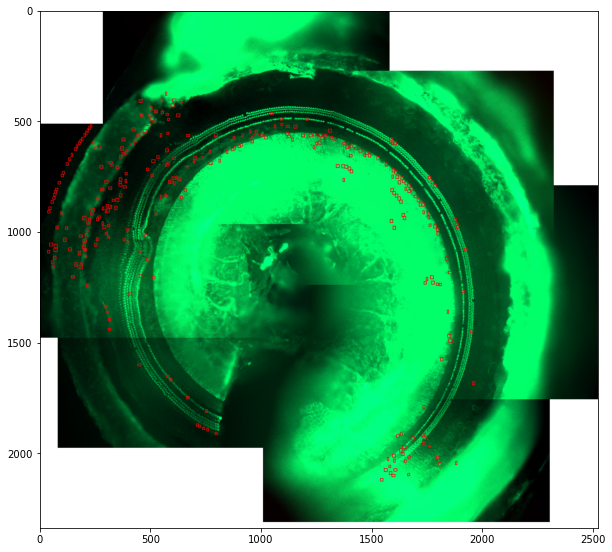

In [421]:
img_rgb1 = cv2.imread('60B.tif')
#img_rgb1 = cv2.imread('40B.jpg')

for (start_x, start_y, end_x, end_y) in actual_display_student[["X_Start","Y_Start","X_End","Y_End"]].values:
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb1)

In [356]:
data = {'Teach_Image': teacher_image_name_list, 'Actual': teacher_actual_target,'Teach_Pedicted':teacher_predicted_target,'Teach_Soft_tgt0':teacher_soft_targets0,'Teach_Soft_tgt1':teacher_soft_targets1}
teacher_data_frame = pd.DataFrame(data)

In [422]:
teacher_data_frame = teacher_data_frame.rename(columns={"Teach_Image":"image_name"})

In [423]:
teacher_data_frame.sort_values(by='image_name',inplace=True)
teacher_data_frame.reset_index(drop=True,inplace=True)

In [424]:
teacher_data_frame_mod=teacher_data_frame.loc[ (teacher_data_frame["Actual"]==1) & (teacher_data_frame["Teach_Pedicted"]==0)]

In [425]:
teacher_data_frame_mod1=teacher_data_frame_mod.set_index('image_name', drop = False)

In [426]:
actual_display_teacher=actual_display1.loc[teacher_data_frame_mod1.index]

In [435]:
teacher_data_frame_mod1

,image_name,Actual,Teach_Pedicted,Teach_Soft_tgt0,Teach_Soft_tgt1
image_name,,,,,
60B_1001.jpg,60B_1001.jpg,1,0,0.916731,-1.111357
60B_1002.jpg,60B_1002.jpg,1,0,3.626089,-3.883599
60B_1003.jpg,60B_1003.jpg,1,0,2.947835,-2.995952
60B_1006.jpg,60B_1006.jpg,1,0,1.206775,-1.522211
60B_1007.jpg,60B_1007.jpg,1,0,0.105018,-0.213802
...,...,...,...,...,...
60B_995.jpg,60B_995.jpg,1,0,5.058358,-5.302254
60B_996.jpg,60B_996.jpg,1,0,3.622674,-3.580454
60B_997.jpg,60B_997.jpg,1,0,1.165426,-1.047927


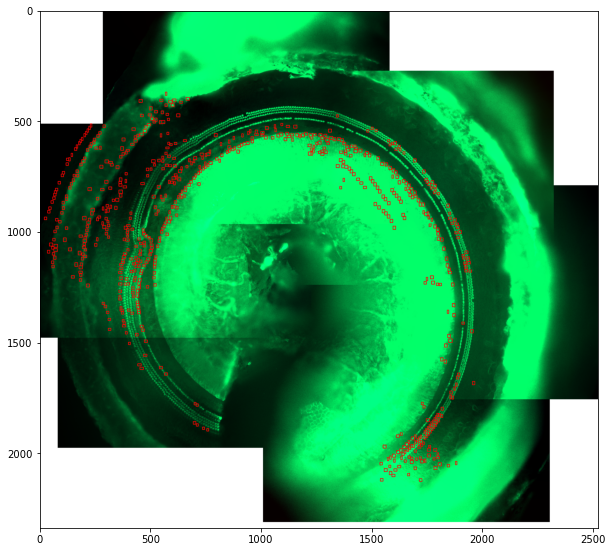

In [427]:
img_rgb1 = cv2.imread('60B.tif')
#img_rgb1 = cv2.imread('40B.jpg')

for (start_x, start_y, end_x, end_y) in actual_display_teacher[["X_Start","Y_Start","X_End","Y_End"]].values:
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb1)

In [368]:
data = {'Self_Dist_Image': distilled_teacher_image_name_list, 'Actual': distilled_teacher_actual_target,'Self_Dist_Pedicted':distilled_teacher_predicted_target,'Self_Dist_Soft_tgt0':distilled_teacher_soft_targets0,'Self_Dist_Soft_tgt1':distilled_teacher_soft_targets1}
self_distill_data_frame = pd.DataFrame(data)


In [428]:
self_distill_data_frame = self_distill_data_frame.rename(columns={"Self_Dist_Image":"image_name"})

In [429]:
self_distill_data_frame.sort_values(by='image_name',inplace=True)
self_distill_data_frame.reset_index(drop=True,inplace=True)

In [430]:
self_distill_data_frame_mod=self_distill_data_frame.loc[ (self_distill_data_frame["Actual"]==1) & (self_distill_data_frame["Self_Dist_Pedicted"]==0)]

In [431]:
self_distill_data_frame_mod1=self_distill_data_frame_mod.set_index('image_name', drop = False)

In [432]:
actual_display_self_distill=actual_display1.loc[self_distill_data_frame_mod1.index]

In [436]:
self_distill_data_frame_mod1

,image_name,Actual,Self_Dist_Pedicted,Self_Dist_Soft_tgt0,Self_Dist_Soft_tgt1
image_name,,,,,
60B_1004.jpg,60B_1004.jpg,1,0,0.367276,-0.266053
60B_1009.jpg,60B_1009.jpg,1,0,0.352086,-0.341954
60B_1010.jpg,60B_1010.jpg,1,0,1.225455,-0.990644
60B_1011.jpg,60B_1011.jpg,1,0,2.360394,-2.340831
60B_1014.jpg,60B_1014.jpg,1,0,0.678054,-0.717404
...,...,...,...,...,...
60B_983.jpg,60B_983.jpg,1,0,2.340629,-1.907337
60B_984.jpg,60B_984.jpg,1,0,1.189852,-1.072462
60B_992.jpg,60B_992.jpg,1,0,0.259725,-0.385022


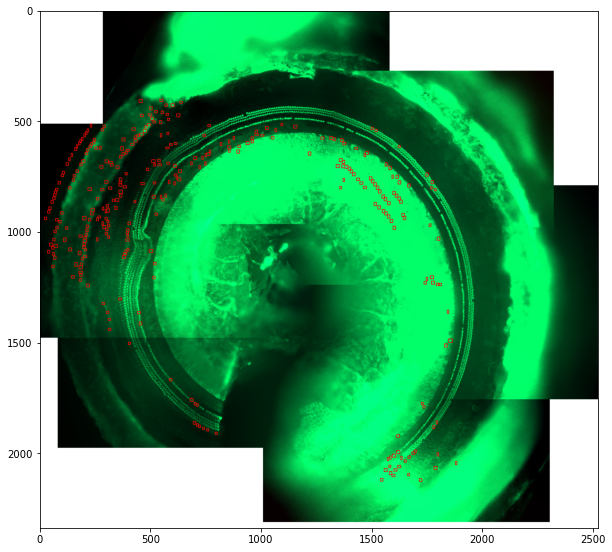

In [433]:
img_rgb1 = cv2.imread('60B.tif')
#img_rgb1 = cv2.imread('40B.jpg')

for (start_x, start_y, end_x, end_y) in actual_display_self_distill[["X_Start","Y_Start","X_End","Y_End"]].values:
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb1)

In [383]:
data = {'Self_Dist_T10_Image': distilled_teacher_T10_image_name_list, 'Actual': distilled_teacher_T10_actual_target,'Self_Dist_T10_Pedicted':distilled_teacher_T10_predicted_target,'Self_Dist_T10_Soft_tgt0':distilled_teacher_T10_soft_targets0,'Self_Dist_T10_Soft_tgt1':distilled_teacher_T10_soft_targets1}
self_distill_T10_data_frame = pd.DataFrame(data)

In [437]:
self_distill_T10_data_frame = self_distill_T10_data_frame.rename(columns={"Self_Dist_T10_Image":"image_name"})

In [439]:
self_distill_T10_data_frame.sort_values(by='image_name',inplace=True)
self_distill_T10_data_frame.reset_index(drop=True,inplace=True)

In [440]:
self_distill_T10_data_frame_mod=self_distill_T10_data_frame.loc[ (self_distill_T10_data_frame["Actual"]==1) & (self_distill_T10_data_frame["Self_Dist_T10_Pedicted"]==0)]

In [441]:
self_distill_T10_data_frame_mod1=self_distill_T10_data_frame_mod.set_index('image_name', drop = False)

In [444]:
self_distill_T10_data_frame_mod1

,image_name,Actual,Self_Dist_T10_Pedicted,Self_Dist_T10_Soft_tgt0,Self_Dist_T10_Soft_tgt1
image_name,,,,,
60B_1009.jpg,60B_1009.jpg,1,0,0.249772,-0.158516
60B_1010.jpg,60B_1010.jpg,1,0,1.133090,-0.964027
60B_1011.jpg,60B_1011.jpg,1,0,1.249633,-1.211413
60B_1014.jpg,60B_1014.jpg,1,0,0.602521,-0.478375
60B_1020.jpg,60B_1020.jpg,1,0,0.428823,-0.028221
...,...,...,...,...,...
60B_970.jpg,60B_970.jpg,1,0,0.931493,-0.471006
60B_976.jpg,60B_976.jpg,1,0,1.969939,-1.854982
60B_977.jpg,60B_977.jpg,1,0,0.393625,-0.547562


In [442]:
actual_display_self_distill_T10=actual_display1.loc[self_distill_T10_data_frame_mod1.index]

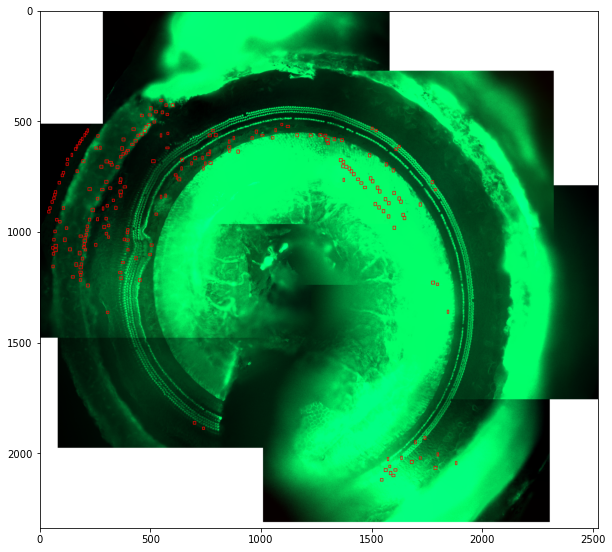

In [445]:
img_rgb1 = cv2.imread('60B.tif')
#img_rgb1 = cv2.imread('40B.jpg')

for (start_x, start_y, end_x, end_y) in actual_display_self_distill_T10[["X_Start","Y_Start","X_End","Y_End"]].values:
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb1)

In [82]:
data_self_distill_rev = {'Self_Dist_rev_Image': distilled_teacher_rev_image_name_list, 'Actual': distilled_teacher_rev_actual_target,'Self_Dist_rev_Pedicted':distilled_teacher_rev_predicted_target,'Self_Dist_rev_Soft_tgt0':distilled_teacher_rev_soft_targets0,'Self_Dist_rev_Soft_tgt1':distilled_teacher_rev_soft_targets1}
self_distill_rev_data_frame = pd.DataFrame(data_self_distill_rev)

In [83]:
self_distill_rev_data_frame = self_distill_rev_data_frame.rename(columns={"Self_Dist_rev_Image":"image_name"})

In [84]:
self_distill_rev_data_frame.sort_values(by='image_name',inplace=True)
self_distill_rev_data_frame.reset_index(drop=True,inplace=True)

In [85]:
self_distill_rev_data_frame_mod=self_distill_rev_data_frame.loc[ (self_distill_rev_data_frame["Actual"]==1) & (self_distill_rev_data_frame["Self_Dist_rev_Pedicted"]==0)]

In [86]:
self_distill_rev_data_frame_mod1=self_distill_rev_data_frame_mod.set_index('image_name', drop = False)

In [88]:
self_distill_rev_data_frame_mod1

,image_name,Actual,Self_Dist_rev_Pedicted,Self_Dist_rev_Soft_tgt0,Self_Dist_rev_Soft_tgt1
image_name,,,,,
60B_1001.jpg,60B_1001.jpg,1,0,0.071292,-0.190711
60B_1002.jpg,60B_1002.jpg,1,0,1.494786,-1.523064
60B_1003.jpg,60B_1003.jpg,1,0,0.993014,-1.266194
60B_1004.jpg,60B_1004.jpg,1,0,0.686218,-0.717211
60B_1006.jpg,60B_1006.jpg,1,0,0.706009,-0.777666
...,...,...,...,...,...
60B_995.jpg,60B_995.jpg,1,0,2.158916,-2.074734
60B_996.jpg,60B_996.jpg,1,0,0.424334,-0.574678
60B_997.jpg,60B_997.jpg,1,0,0.105897,-0.064690


In [109]:
actual_display_self_distill_rev=actual_display1.loc[self_distill_rev_data_frame_mod1.index]

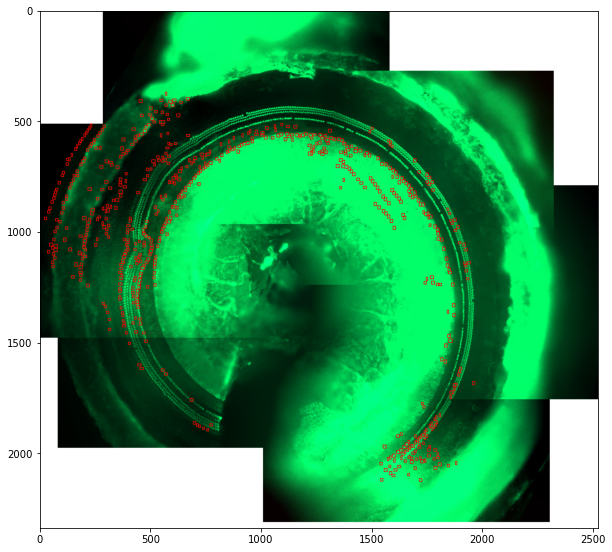

In [110]:
img_rgb1 = cv2.imread('60B.tif')
#img_rgb1 = cv2.imread('40B.jpg')

for (start_x, start_y, end_x, end_y) in actual_display_self_distill_rev[["X_Start","Y_Start","X_End","Y_End"]].values:
    cv2.rectangle(img_rgb1, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb1)